In [45]:
import os
import pandas as pd
import torch
import numpy as np
from transformers import BertTokenizer, BertForSequenceClassification, get_scheduler
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [46]:
# Load preprocessed data
train_df = pd.read_csv("processed/train_cleaned.csv")
dev_df = pd.read_csv("processed/dev_cleaned.csv")
test_df = pd.read_csv("processed/test_cleaned.csv")

# Initialize LabelEncoder and fit on TRAIN data only
label_encoder = LabelEncoder()
train_df["label_encoded"] = label_encoder.fit_transform(train_df["label"])

# Ensure dev and test datasets only contain known labels
valid_labels = set(train_df["label"].unique())  # Known labels from training data

# Remove rows with unseen labels in dev & test sets
dev_df = dev_df[dev_df["label"].isin(valid_labels)]
test_df = test_df[test_df["label"].isin(valid_labels)]

# Encode dev and test labels (Now they should match training labels)
dev_df["label_encoded"] = label_encoder.transform(dev_df["label"])
test_df["label_encoded"] = label_encoder.transform(test_df["label"])

# Save label mapping for decoding predictions later
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

# Select text features (Using 'claim_cleaned')
train_texts, train_labels = train_df["claim_cleaned"].tolist(), train_df["label_encoded"].tolist()
dev_texts, dev_labels = dev_df["claim_cleaned"].tolist(), dev_df["label_encoded"].tolist()
test_texts, test_labels = test_df["claim_cleaned"].tolist(), test_df["label_encoded"].tolist()

print(f"✅ Data Loaded: {len(train_texts)} train, {len(dev_texts)} dev, {len(test_texts)} test samples.")

✅ Data Loaded: 9806 train, 1216 dev, 1235 test samples.


In [47]:
# Load BERT Tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Tokenization function
def tokenize_data(texts, labels, tokenizer, max_len=256):
    inputs = tokenizer(
        texts, padding=True, truncation=True, max_length=max_len, return_tensors="pt"
    )
    return {
        "input_ids": inputs["input_ids"],
        "attention_mask": inputs["attention_mask"],
        "labels": torch.tensor(labels),
    }

# Apply tokenization
train_data = tokenize_data(train_df["claim_cleaned"].tolist(), train_df["label_encoded"].tolist(), tokenizer)
dev_data = tokenize_data(dev_df["claim_cleaned"].tolist(), dev_df["label_encoded"].tolist(), tokenizer)
test_data = tokenize_data(test_df["claim_cleaned"].tolist(), test_df["label_encoded"].tolist(), tokenizer)

In [48]:
# Custom Dataset Class
class PubHealthDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data["input_ids"])

    def __getitem__(self, idx):
        return {
            "input_ids": self.data["input_ids"][idx],
            "attention_mask": self.data["attention_mask"][idx],
            "labels": self.data["labels"][idx],
        }

# Create Dataset Objects
train_dataset = PubHealthDataset(train_data)
dev_dataset = PubHealthDataset(dev_data)
test_dataset = PubHealthDataset(test_data)

# Define Batch Size
BATCH_SIZE = 8

# Create Dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

print("✅ Dataloaders Created!")

✅ Dataloaders Created!


In [49]:
# Load BERT Model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(label_mapping))

device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print(f"✅ BERT Model Loaded on {device}!")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ BERT Model Loaded on mps!


In [50]:
from transformers import get_scheduler
from torch.optim import AdamW

# Set MPS device (for Apple Silicon)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# Define optimizer & scheduler
optimizer = AdamW(model.parameters(), lr=1e-5, weight_decay=1e-2)

# Use a dynamic learning rate scheduler
num_training_steps = len(train_loader) * 5  # 5 epochs
scheduler = get_scheduler(
    "linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

# Loss function
loss_fn = torch.nn.CrossEntropyLoss()

In [51]:
# Updated training function
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler):
    model.train()
    total_loss, correct_predictions = 0, 0

    for batch in data_loader:
        optimizer.zero_grad()

        input_ids, attention_mask, labels = (
            batch["input_ids"].to(device),
            batch["attention_mask"].to(device),
            batch["labels"].to(device)
        )

        outputs = model(input_ids, attention_mask=attention_mask)
        loss = loss_fn(outputs.logits, labels)

        loss.backward()
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()
        correct_predictions += (outputs.logits.argmax(dim=1) == labels).sum().item()

    return correct_predictions / len(data_loader.dataset), total_loss / len(data_loader)

# Train BERT
EPOCHS = 5
for epoch in range(EPOCHS):
    print(f"\n===== Epoch {epoch + 1}/{EPOCHS} =====")
    train_acc, train_loss = train_epoch(model, train_loader, loss_fn, optimizer, device, scheduler)
    print(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_acc:.4f}")

print("✅ Improved BERT Model Training Completed!")


===== Epoch 1/5 =====
Train Loss: 0.9281 | Train Accuracy: 0.6102

===== Epoch 2/5 =====
Train Loss: 0.7608 | Train Accuracy: 0.6728

===== Epoch 3/5 =====
Train Loss: 0.6342 | Train Accuracy: 0.7286

===== Epoch 4/5 =====
Train Loss: 0.5024 | Train Accuracy: 0.7905

===== Epoch 5/5 =====
Train Loss: 0.4049 | Train Accuracy: 0.8440
✅ Improved BERT Model Training Completed!


In [53]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Evaluation function
def evaluate_model(model, data_loader, device):
    model.eval()
    predictions, true_labels = [], []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)

            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    return predictions, true_labels

# Run Evaluation
y_pred, y_true = evaluate_model(model, test_loader, device)

# Compute Metrics (Fix: zero_division=1)
accuracy = accuracy_score(y_true, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted", zero_division=1)

# Print Results
print(f"✅ Model Accuracy: {accuracy:.4f}")
print(f"✅ Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

✅ Model Accuracy: 0.6421
✅ Precision: 0.6399, Recall: 0.6421, F1-Score: 0.6338


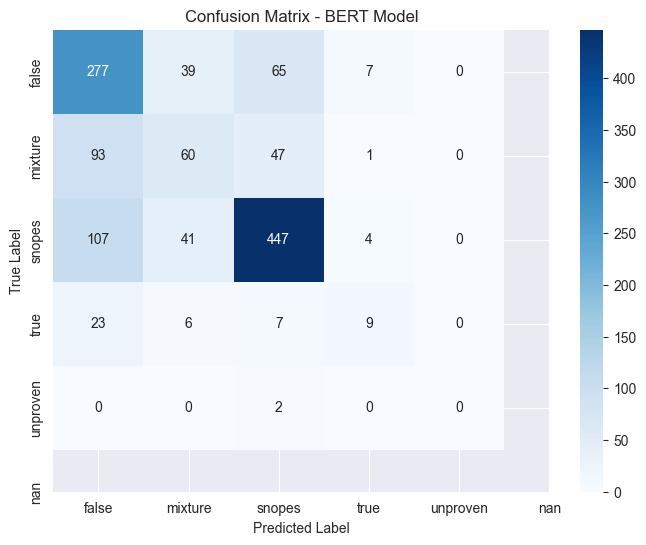

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - BERT Model")
plt.show()